# Spark GraphFrames

In [2]:
import numpy as np

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [4]:
from pyspark.sql.types import *
from graphframes import *

In [5]:
import graphframes

**Notes on installing GraphFrames**

I needed to put the GraphFrames jar file into the Spark jars director for it to work.

```bash
cd /usr/local/spark/jars/
wget http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.7.0-spark2.4-s_2.11/graphframes-0.7.0-spark2.4-s_2.11.jar
```

In [6]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
G = nx.les_miserables_graph()

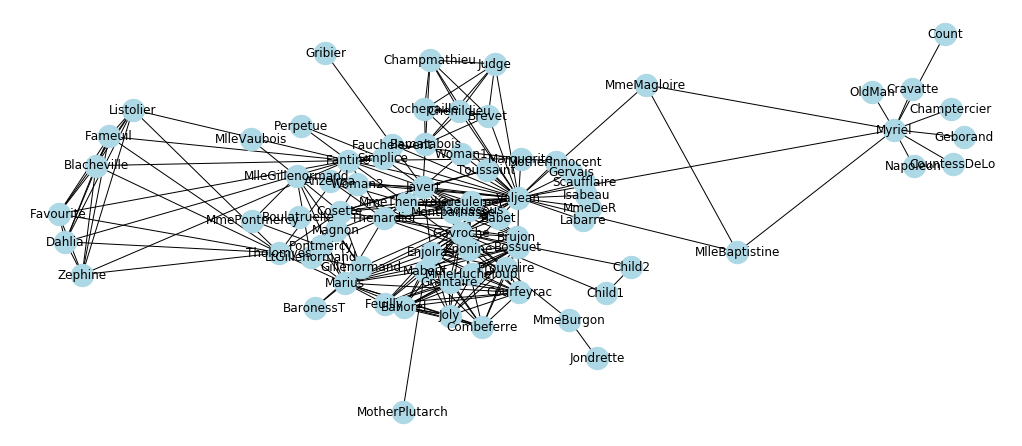

In [9]:
plt.figure(figsize=(14, 6))
nx.draw_kamada_kawai(
    G, 
    with_labels=True, 
    node_size=500, 
    node_color='lightblue' 
)

In [10]:
np.random.seed(123)

In [11]:
edges = [(a, b, np.random.randint(1, 4)) for (a, b) in nx.edges(G)]

In [12]:
nodes = [(name, name, np.random.randint(15, 60)) for name in nx.nodes(G)]

In [13]:
edges[:3]

[('Napoleon', 'Myriel', 3),
 ('Myriel', 'MlleBaptistine', 2),
 ('Myriel', 'MmeMagloire', 3)]

In [14]:
nodes[:3]

[('Napoleon', 'Napoleon', 43),
 ('Myriel', 'Myriel', 50),
 ('MlleBaptistine', 'MlleBaptistine', 34)]

## Creation of a GraphFrame

- Need to provide a DataFrame of vertices, and a DataFrame of edges

### Vertices must contain an id column

In [15]:
v = spark.createDataFrame(nodes, ['id', 'name', 'age'])

### Edges must have src and dst columns that contain vertex ids

In [16]:
e = spark.createDataFrame(edges, ['src', 'dst', 'wt'])

In [17]:
g = GraphFrame(v, e)

## Basic information

In [18]:
g

GraphFrame(v:[id: string, name: string ... 1 more field], e:[src: string, dst: string ... 1 more field])

In [19]:
g.vertices.show(5)

+--------------+--------------+---+
|            id|          name|age|
+--------------+--------------+---+
|      Napoleon|      Napoleon| 43|
|        Myriel|        Myriel| 50|
|MlleBaptistine|MlleBaptistine| 34|
|   MmeMagloire|   MmeMagloire| 32|
|  CountessDeLo|  CountessDeLo| 54|
+--------------+--------------+---+
only showing top 5 rows



In [20]:
g.edges.show(5)

+--------+--------------+---+
|     src|           dst| wt|
+--------+--------------+---+
|Napoleon|        Myriel|  3|
|  Myriel|MlleBaptistine|  2|
|  Myriel|   MmeMagloire|  3|
|  Myriel|  CountessDeLo|  3|
|  Myriel|      Geborand|  1|
+--------+--------------+---+
only showing top 5 rows



## Search

In [21]:
from pyspark.sql.functions import col, desc

In [22]:
g.vertices.show(5)

+--------------+--------------+---+
|            id|          name|age|
+--------------+--------------+---+
|      Napoleon|      Napoleon| 43|
|        Myriel|        Myriel| 50|
|MlleBaptistine|MlleBaptistine| 34|
|   MmeMagloire|   MmeMagloire| 32|
|  CountessDeLo|  CountessDeLo| 54|
+--------------+--------------+---+
only showing top 5 rows



### Can use regular DataFrame functions

In [23]:
g.vertices.filter(col('name').startswith('C')).show(5)

+------------+------------+---+
|          id|        name|age|
+------------+------------+---+
|CountessDeLo|CountessDeLo| 54|
|Champtercier|Champtercier| 55|
|    Cravatte|    Cravatte| 29|
|       Count|       Count| 29|
|     Cosette|     Cosette| 54|
+------------+------------+---+
only showing top 5 rows



In [24]:
g.edges.groupBy('wt').count().show()

+---+-----+
| wt|count|
+---+-----+
|  1|   79|
|  3|   86|
|  2|   89|
+---+-----+



## Motifs

In [25]:
g.find('(a)').show(5)

+--------------------+
|                   a|
+--------------------+
|[Napoleon, Napole...|
|[Myriel, Myriel, 50]|
|[MlleBaptistine, ...|
|[MmeMagloire, Mme...|
|[CountessDeLo, Co...|
+--------------------+
only showing top 5 rows



In [26]:
g.find('(a)-[e]->(b)').show(5, truncate=False)

+--------------------------+-----------------------+----------------------+
|a                         |e                      |b                     |
+--------------------------+-----------------------+----------------------+
|[Prouvaire, Prouvaire, 32]|[Prouvaire, Bahorel, 3]|[Bahorel, Bahorel, 45]|
|[Marius, Marius, 40]      |[Marius, Bahorel, 3]   |[Bahorel, Bahorel, 45]|
|[Feuilly, Feuilly, 36]    |[Feuilly, Bahorel, 2]  |[Bahorel, Bahorel, 45]|
|[Mabeuf, Mabeuf, 44]      |[Mabeuf, Bahorel, 2]   |[Bahorel, Bahorel, 45]|
|[Gavroche, Gavroche, 52]  |[Gavroche, Bahorel, 3] |[Bahorel, Bahorel, 45]|
+--------------------------+-----------------------+----------------------+
only showing top 5 rows



In [27]:
g.find('(a)-[e1]->(b); (b)-[e2]->(c)').select('e1', 'e2').show(5, truncate=False)

+---------------------------+-----------------------+
|e1                         |e2                     |
+---------------------------+-----------------------+
|[Gavroche, Prouvaire, 1]   |[Prouvaire, Bahorel, 3]|
|[Enjolras, Prouvaire, 3]   |[Prouvaire, Bahorel, 3]|
|[Combeferre, Prouvaire, 2] |[Prouvaire, Bahorel, 3]|
|[LtGillenormand, Marius, 2]|[Marius, Bahorel, 3]   |
|[Valjean, Marius, 3]       |[Marius, Bahorel, 3]   |
+---------------------------+-----------------------+
only showing top 5 rows



In [28]:
g.find('(a)-[]->(b); !(b)-[]->(a)').show(5, truncate=False)

+----------------------------------+----------------------------+
|a                                 |b                           |
+----------------------------------+----------------------------+
|[Gavroche, Gavroche, 52]          |[Combeferre, Combeferre, 44]|
|[Eponine, Eponine, 22]            |[Marius, Marius, 40]        |
|[Enjolras, Enjolras, 21]          |[Joly, Joly, 45]            |
|[Marius, Marius, 40]              |[Courfeyrac, Courfeyrac, 31]|
|[MmeThenardier, MmeThenardier, 57]|[Gueulemer, Gueulemer, 34]  |
+----------------------------------+----------------------------+
only showing top 5 rows



In [29]:
g.find('(a)-[]->(b); (b)-[]->(a)').show(5, truncate=False)

+---+---+
|a  |b  |
+---+---+
+---+---+



## Extracting subgraphs

In [55]:
g1 = g.filterVertices("age > 30").filterEdges('wt < 3').dropIsolatedVertices()

In [56]:
g.vertices.count()

77

In [57]:
g1.vertices.count()

49

## Pathfinding

In [58]:
path = g.bfs("name = 'Cosette'", "age > 30")

In [59]:
path.show(truncate=False)

+----------------------+----------------------+
|from                  |to                    |
+----------------------+----------------------+
|[Cosette, Cosette, 54]|[Cosette, Cosette, 54]|
+----------------------+----------------------+



In [66]:
path = g.bfs("name = 'Cosette'", "age = 50")

In [67]:
path.show(truncate=False)

+----------------------+------------------------------+----------------------------------------+----------------------------------+------------------------------+
|from                  |e0                            |v1                                      |e1                                |to                            |
+----------------------+------------------------------+----------------------------------------+----------------------------------+------------------------------+
|[Cosette, Cosette, 54]|[Cosette, MlleGillenormand, 2]|[MlleGillenormand, MlleGillenormand, 56]|[MlleGillenormand, MlleVaubois, 3]|[MlleVaubois, MlleVaubois, 50]|
|[Cosette, Cosette, 54]|[Cosette, Javert, 3]          |[Javert, Javert, 41]                    |[Javert, Bamatabois, 2]           |[Bamatabois, Bamatabois, 50]  |
+----------------------+------------------------------+----------------------------------------+----------------------------------+------------------------------+



In [95]:
paths = g.shortestPaths(landmarks = ['Cosette'])

In [101]:
paths.sort('id').show(100)

+----------------+----------------+---+--------------+
|              id|            name|age|     distances|
+----------------+----------------+---+--------------+
|         Anzelma|         Anzelma| 54|            []|
|           Babet|           Babet| 31|            []|
|         Bahorel|         Bahorel| 45|            []|
|      Bamatabois|      Bamatabois| 50|            []|
|       BaronessT|       BaronessT| 48|            []|
|     Blacheville|     Blacheville| 36|[Cosette -> 3]|
|         Bossuet|         Bossuet| 31|            []|
|    Boulatruelle|    Boulatruelle| 45|            []|
|          Brevet|          Brevet| 25|            []|
|          Brujon|          Brujon| 52|            []|
|    Champmathieu|    Champmathieu| 40|            []|
|    Champtercier|    Champtercier| 55|            []|
|      Chenildieu|      Chenildieu| 15|            []|
|          Child1|          Child1| 22|            []|
|          Child2|          Child2| 57|            []|
|      Cla

## Centrality

In [104]:
g.degrees.show(5)

+--------------+------+
|            id|degree|
+--------------+------+
|      Napoleon|     1|
|       Bahorel|    12|
|LtGillenormand|     4|
|       Isabeau|     1|
|MotherPlutarch|     1|
+--------------+------+
only showing top 5 rows



In [106]:
g.inDegrees.show(5)

+--------------+--------+
|            id|inDegree|
+--------------+--------+
|       Bahorel|       8|
|LtGillenormand|       3|
|       Isabeau|       1|
|MotherPlutarch|       1|
|        Woman1|       2|
+--------------+--------+
only showing top 5 rows



In [107]:
g.outDegrees.show(5)

+--------------+---------+
|            id|outDegree|
+--------------+---------+
|      Napoleon|        1|
|       Bahorel|        4|
|LtGillenormand|        1|
|     Prouvaire|        6|
|     Gueulemer|        4|
+--------------+---------+
only showing top 5 rows



In [108]:
res = g.pageRank(resetProbability=0.15, maxIter=5)

In [118]:
res.vertices.sort(desc('pagerank')).show(5, truncate=False)

+------------+------------+---+------------------+
|id          |name        |age|pagerank          |
+------------+------------+---+------------------+
|MmeHucheloup|MmeHucheloup|29 |6.066220383073121 |
|Brujon      |Brujon      |52 |3.55362985572279  |
|Grantaire   |Grantaire   |27 |3.193717498086595 |
|Cochepaille |Cochepaille |50 |3.003719316794456 |
|Fantine     |Fantine     |49 |2.9555269920134815|
+------------+------------+---+------------------+
only showing top 5 rows



In [121]:
res = g.pageRank(resetProbability=0.15, maxIter=5, sourceId='Cosette')

In [122]:
res.vertices.sort(desc('pagerank')).show(5, truncate=False)

+------------+------------+---+-------------------+
|id          |name        |age|pagerank           |
+------------+------------+---+-------------------+
|Cosette     |Cosette     |54 |0.2641465158300428 |
|MmeHucheloup|MmeHucheloup|29 |0.11029953528745304|
|Marius      |Marius      |40 |0.08428654885997462|
|Grantaire   |Grantaire   |27 |0.061926545711472  |
|Joly        |Joly        |45 |0.04619059103412592|
+------------+------------+---+-------------------+
only showing top 5 rows



## Community detection

In [123]:
sc = spark.sparkContext
sc.setCheckpointDir("checkpoint")

In [124]:
res = g1.connectedComponents()

In [129]:
res.select('component').distinct().show()

+-----------+
|  component|
+-----------+
|34359738368|
+-----------+



In [130]:
res.orderBy('component').show(5, truncate=False)

+---------+---------+---+-----------+
|id       |name     |age|component  |
+---------+---------+---+-----------+
|Bahorel  |Bahorel  |45 |34359738368|
|Prouvaire|Prouvaire|32 |34359738368|
|Gueulemer|Gueulemer|34 |34359738368|
|Isabeau  |Isabeau  |31 |34359738368|
|MmeBurgon|MmeBurgon|44 |34359738368|
+---------+---------+---+-----------+
only showing top 5 rows



In [131]:
res = g1.stronglyConnectedComponents(maxIter=5)

In [136]:
res.groupBy('component').count().filter('count > 1').show()

+---------+-----+
|component|count|
+---------+-----+
+---------+-----+



In [134]:
res.orderBy('component').show(10, truncate=False)

+--------------+--------------+---+------------+
|id            |name          |age|component   |
+--------------+--------------+---+------------+
|Bahorel       |Bahorel       |45 |34359738368 |
|Isabeau       |Isabeau       |31 |137438953472|
|Prouvaire     |Prouvaire     |32 |223338299392|
|Gueulemer     |Gueulemer     |34 |240518168576|
|Marius        |Marius        |40 |266287972352|
|MmeBurgon     |MmeBurgon     |44 |300647710720|
|Feuilly       |Feuilly       |36 |395136991232|
|MotherInnocent|MotherInnocent|34 |403726925824|
|Valjean       |Valjean       |43 |481036337152|
|Mabeuf        |Mabeuf        |44 |489626271744|
+--------------+--------------+---+------------+
only showing top 10 rows



In [137]:
res = g.triangleCount()

In [139]:
res.show(5, truncate=False)

+-----+--------------+--------------+---+
|count|id            |name          |age|
+-----+--------------+--------------+---+
|0    |Napoleon      |Napoleon      |43 |
|57   |Bahorel       |Bahorel       |45 |
|6    |LtGillenormand|LtGillenormand|28 |
|0    |Isabeau       |Isabeau       |31 |
|0    |MotherPlutarch|MotherPlutarch|41 |
+-----+--------------+--------------+---+
only showing top 5 rows



In [140]:
res = g.labelPropagation(maxIter=5)

In [143]:
res.groupBy('label').count().filter('count > 1').show()

+-------------+-----+
|        label|count|
+-------------+-----+
|1511828488192|   20|
| 515396075520|    6|
|1005022347264|   23|
| 609885356032|   10|
|1400159338496|    7|
| 481036337152|   10|
+-------------+-----+

